cuda


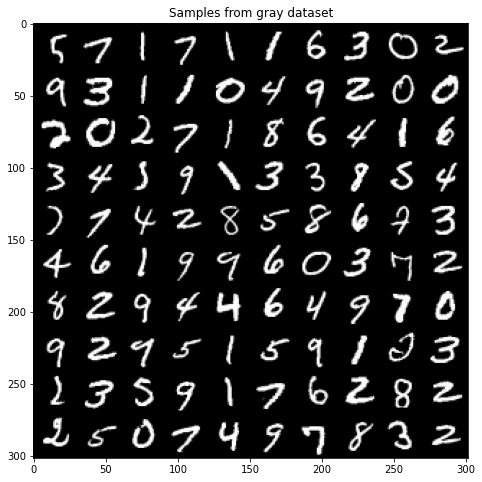

In [34]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.categorical import Categorical
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import pickle

from utils import LabelToImageNet


# %%
writer = SummaryWriter()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)


# %%
def to_binary(x):
    zero_mask = x < 0.5
    x[zero_mask] = 0.
    x[~zero_mask] = 1.
    return x

train_dataset_gray = datasets.MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor()
]))

test_dataset_gray = datasets.MNIST('./data', train=False, transform=transforms.Compose([
    transforms.ToTensor()
]))

train_dataset_binary = datasets.MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    to_binary
]))

test_dataset_binary = datasets.MNIST('./data', train=False, transform=transforms.Compose([
    transforms.ToTensor(),
    to_binary
]))


N_val = 1000
N_train = len(train_dataset_binary) - N_val
N_test = len(test_dataset_binary)


# %%
def make_image_grid(images, nrow=8):
    images = images.float()  # from {0,1,2,3} ints to [0,1] floats
    grid = torchvision.utils.make_grid(images, nrow)
    grid = grid.permute(1, 2, 0).cpu().numpy()  # from CHW to HWC
    return grid

plt.figure(figsize=(8, 8))
plt.title('Samples from gray dataset')
it = iter(train_dataset_gray)

imgs = []
labels = []
for i in range(100):
    element = next(it)
    imgs.append(element[0])
    labels.append(element[1])

labels = np.array(labels).reshape((10, 10))
    
plt.imshow(make_image_grid(torch.stack([next(it)[0] for _ in range(100)], dim=0), nrow=10))
del it



torch.Size([1, 28, 28])


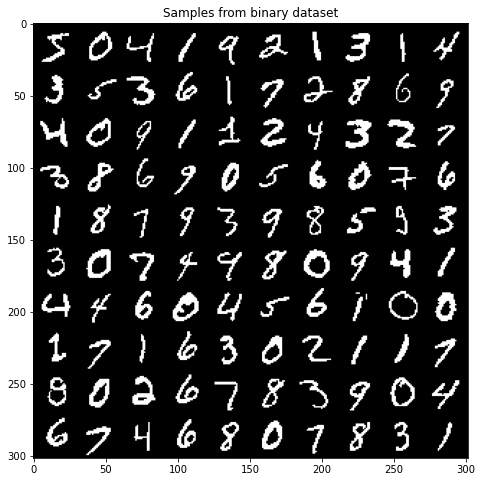

In [36]:
# %%
plt.figure(figsize=(8, 8))
plt.title('Samples from binary dataset')
it = iter(train_dataset_binary)

imgs = []
labels = []
for i in range(100):
    element = next(it)
    imgs.append(element[0])
    labels.append(element[1])

labels = np.array(labels).reshape((10, 10))
    
plt.imshow(make_image_grid(torch.stack(imgs, dim=0), nrow=10))
print(imgs[0].size())
del it


In [ ]:
class VAE(nn.Module):
    def __init__(self, output_size=28*28):
        super().__init__()
        
        self.hidden_1 = nn.Linear(1, 20)
        self.hidden_2 = nn.Linear(20, 10)
        self.hidden_3 = nn.Linear(10, 10)
        self.hidden_4 = nn.Linear(10, 250)
        self.hidden_5 = nn.Linear(250, 500)
        self.hidden_6 = nn.Linear(500, 28*28)
        #self.hidden_3 = nn.Linear(500, 250)
        #self.hidden_4 = nn.Linear(250, 28*28)
        #self.hidden_5 = nn.Linear(*16, 28*28)        
    
    def forward(self, x):
        #x = torch.Tensor([[int(i == z) for i in range(10)] for z in x]).to(device).float()
        x = self.hidden_1(x)
        x =F.relu(x)
        x = self.hidden_2(x)
        x = F.relu(x)
        x = self.hidden_3(x)
        x = F.relu(x)
        x = self.hidden_4(x)
        x = F.relu(x)
        x = self.hidden_5(x)
        x = F.relu(x)
        x = self.hidden_6(x)
        #x = F.relu(x)
        x = torch.sigmoid(x)
        return x

# %%
lr = 1e-3
reg = 1e-4
batch_size = 256
hidden_size = 64  # h variable in PixelCNN
num_residual_blocks = 12
num_feature_maps = 128  # size of the hidden output layer
batch_norm = True
num_input_channels = 1
num_output_classes = 2
flatten_img_size = 28 * 28


def sample_mnist_pixel_cnn(model, n_classes):
    outputs = []
    for i in range(n_classes):
        print()
        outputs.append(
            torch.reshape(
                model(torch.tensor([i]).to(device).float()),
                (1, 28, 28)
                )
            )
    return torch.stack(outputs, dim=0)


# %%

# alternatively model = torch.nn.Sequential( ?? )
def flatten_processor(output):
    return torch.flatten(output)

def make_float_processor(imgs):
    return imgs.float()


def train(model, train_loader, val_loader, loss, custom_loss=False, mse=False, save_path='./data/test', num_epochs=100):
    train_nll_history = []
    val_nll_history = []
    optimizer = optim.Adam(model.parameters(), lr, weight_decay=reg)
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs} ', end='')
        
        model.train()
        for i, minibatch in enumerate(train_loader):
            optimizer.zero_grad()
            labels = torch.reshape(minibatch[1].to(device), (-1, 1)).float()
            imgs = torch.flatten(torch.reshape(minibatch[0].to(device), (-1, flatten_img_size)))

            output = model(labels)
            
            if mse:
                nll = loss(torch.flatten(output), imgs.float())
            else:
                if not custom_loss:
                    outputs = torch.stack(
                        [torch.flatten(1 - output), torch.flatten(output)], dim=1
                    )
                    nll = loss(outputs, imgs.long())

                else:
                    outputs = torch.flatten(output)
                    nll = loss(outputs, imgs)

            nll.backward()
            optimizer.step()
            
            train_nll_history.append(nll.item() / np.log(2.) / 2.)
            
            if i % 50 == 0:
                print('.', end='')
        
        train_loss = np.mean(train_nll_history) / np.log(2.) / 2.
        writer.add_scalar("Loss/train", train_loss, epoch)


        # compute nll on validation set
        val_nlls = []
        model.eval()
        with torch.no_grad():
            for val_minibatch in val_loader:
                val_labels = torch.reshape(minibatch[1].to(device), (-1, 1)).float()
                val_imgs = torch.flatten(torch.reshape(minibatch[0].to(device), (-1, flatten_img_size)))

                output = model(val_labels)
                if mse:
                    val_nll = loss(torch.flatten(output), imgs.float())
                else:
                    if not custom_loss:
                        outputs = torch.stack(
                            [torch.flatten(1 - output), torch.flatten(output)], dim=1
                        )
                        val_nll = loss(outputs, imgs.long())

                    else:
                        outputs = torch.flatten(output)
                        val_nll = loss(outputs, imgs)

            
                val_nlls.append(val_nll.item())
        val_loss = np.mean(val_nlls) / np.log(2.) / 2.

        writer.add_scalar("Loss/val", val_loss, epoch)
        val_nll_history.append(val_loss)
        print("loss: ", val_loss)
        
        samples = sample_mnist_pixel_cnn(model, 10).detach()
        #plt.figure(figsize=(6,3))
        img = make_image_grid(samples, nrow=5)
        plt.imsave(os.path.join(save_path, f'epoch_{epoch}.jpg'), img)
        #plt.show()
        

    writer.flush()


def custom_crossentropy(output, target):
    return torch.sum(-target * torch.log(output) - (1 - target) * torch.log(1 - output)) / output.size()[0]


#gray_cross_module_nn
#model = LabelToImageNet().to(device)
#train_loader = torch.utils.data.DataLoader(train_dataset_gray, batch_size=batch_size,
#                                           sampler=SubsetRandomSampler(list(range(N_train))))
#val_loader = torch.utils.data.DataLoader(train_dataset_gray, batch_size=batch_size,
#                                         sampler=SubsetRandomSampler(list(range(N_train, N_train + N_val))))
#train(model, train_loader, val_loader, custom_crossentropy, custom_loss=True, mse=False, save_path='./data/gray_cross_module_nn', num_epochs=100)



#binary_cross_module_nn
#model = LabelToImageNet().to(device)
#train_loader = torch.utils.data.DataLoader(train_dataset_binary, batch_size=batch_size,
#                                           sampler=SubsetRandomSampler(list(range(N_train))))
#val_loader = torch.utils.data.DataLoader(train_dataset_binary, batch_size=batch_size,
#                                         sampler=SubsetRandomSampler(list(range(N_train, N_train + N_val))))
#train(model, train_loader, val_loader, nn.CrossEntropyLoss(), mse=False, save_path='./data/binary_cross_module_nn', num_epochs=100)


#binary_cross_sequential
#model = get_sequential_model().to(device)
#train_loader = torch.utils.data.DataLoader(train_dataset_binary, batch_size=batch_size,
#                                           sampler=SubsetRandomSampler(list(range(N_train))))
#val_loader = torch.utils.data.DataLoader(train_dataset_binary, batch_size=batch_size,
#                                         sampler=SubsetRandomSampler(list(range(N_train, N_train + N_val))))
#train(model, train_loader, val_loader, nn.CrossEntropyLoss(), mse=False, save_path='./data/binary_cross_sequential', num_epochs=100)


#gray_mse_sequential
#model = get_sequential_model().to(device)
#train_loader = torch.utils.data.DataLoader(train_dataset_gray, batch_size=batch_size,
#                                           sampler=SubsetRandomSampler(list(range(N_train))))
#val_loader = torch.utils.data.DataLoader(train_dataset_gray, batch_size=batch_size,
#                                         sampler=SubsetRandomSampler(list(range(N_train, N_train + N_val))))
#train(model, train_loader, val_loader, nn.MSELoss(), mse=True, save_path='./data/gray_mse_sequential', num_epochs=30)


#binary_mse_sequential
#model = get_sequential_model().to(device)
#train_loader = torch.utils.data.DataLoader(train_dataset_binary, batch_size=batch_size,
#                                           sampler=SubsetRandomSampler(list(range(N_train))))
#val_loader = torch.utils.data.DataLoader(train_dataset_binary, batch_size=batch_size,
#                                         sampler=SubsetRandomSampler(list(range(N_train, N_train + N_val))))

#train(model, train_loader, val_loader, nn.MSELoss(), mse=True, save_path='./data/binary_mse_sequential', num_epochs=100)

class SimpleEncoder(nn.Module):
    def __init__(self, latent_space_size):
        super(SimpleEncoder, self).__init__()
        self.hidden_1 = nn.Linear(28 * 28, 512)
        self.hidden_2 = nn.Linear(512, 256)
        self.hidden_3 = nn.Linear(256, 128)

        self.mean = nn.Linear(128, latent_space_size)
        self.log_std = nn.Linear(128, latent_space_size)

    def forward(self, x):
        x = self.hidden_1(x)
        x = F.relu(x)
        x = self.hidden_2(x)
        x = F.relu(x)
        x = self.hidden_3(x)
        x = F.relu(x)

        return self.mean(x), self.log_std(x)

class SimpleDecoder(nn.Module):
    def __init__(self, latent_space_size):
        super(SimpleDecoder, self).__init__()
        self.hidden_1 = nn.Linear(latent_space_size, 128)
        self.hidden_2 = nn.Linear(128, 256)
        self.hidden_3 = nn.Linear(256, 512)
        self.result = nn.Linear(512, 28 * 28)

    def forward(self, x):
        x = self.hidden_1(x)
        x = F.relu(x)
        x = self.hidden_2(x)
        x = F.relu(x)
        x = self.hidden_3(x)
        x = F.relu(x)
        return torch.sigmoid(self.result(x))#, self.log_std(x)


class Encoder(nn.Module):
    def __init__(self, latent_space_size):
        super(Encoder, self).__init__()
        self.hidden_1 = nn.Linear(28 * 28, 500)
        self.hidden_2 = nn.Linear(500, 250)
        self.hidden_3 = nn.Linear(250, 10)
        self.hidden_4 = nn.Linear(10, 10)
        self.hidden_5 = nn.Linear(10, 20)
        self.hidden_6 = nn.Linear(20, 10)

        self.mean = nn.Linear(10, latent_space_size)
        self.log_std = nn.Linear(10, latent_space_size)

    def forward(self, x):
        x = self.hidden_1(x)
        x = F.relu(x)
        x = self.hidden_2(x)
        x = F.relu(x)
        x = self.hidden_3(x)
        x = F.relu(x)
        x = self.hidden_4(x)
        x = F.relu(x)
        x = self.hidden_5(x)
        x = F.relu(x)
        x = self.hidden_6(x)
        x = F.relu(x)

        return self.mean(x), self.log_std(x)


class Decoder(nn.Module):
    def __init__(self, latent_space_size):
        super(Decoder, self).__init__()
        self.hidden_1 = nn.Linear(latent_space_size, 10)
        self.hidden_2 = nn.Linear(10, 20)
        self.hidden_3 = nn.Linear(20, 10)
        self.hidden_4 = nn.Linear(10, 10)
        self.hidden_5 = nn.Linear(10, 250)
        self.hidden_6 = nn.Linear(250, 500)
        self.result = nn.Linear(500, 28 * 28)
        # self.mean = nn.Linear(500, 28 * 28)

        # self.log_std = nn.Linear(500, 28 * 28)

    def forward(self, x):
        x = self.hidden_1(x)
        x = F.relu(x)
        x = self.hidden_2(x)
        x = F.relu(x)
        x = self.hidden_3(x)
        x = F.relu(x)
        x = self.hidden_4(x)
        x = F.relu(x)
        x = self.hidden_5(x)
        x = F.relu(x)
        x = self.hidden_6(x)
        x = F.relu(x)

        return torch.sigmoid(self.result(x))#, self.log_std(x)


class VAE(nn.Module):
    def __init__(self, n_inputs, latent_space_size, simple=False):
        super(VAE, self).__init__()
        self.latent_space_size = latent_space_size
        if simple:
            self.encoder = SimpleEncoder(latent_space_size)
            self.decoder = SimpleDecoder(latent_space_size)
        else:
            self.encoder = Encoder(latent_space_size)
            self.decoder = Decoder(latent_space_size)
    
    def sample_latent(self, m_z, log_std_z):
        if self.training:
            #print('in training')
            eps = torch.randn_like(m_z)
            sample = eps * log_std_z.exp() + m_z
            return sample
        else:
            return m_z

    def forward(self, x):
        m_z, log_std_z = self.encoder(x)
        z = self.sample_latent(m_z, log_std_z)
        # mu_x, log_std_x = self.decoder(z)
        reconstruction = self.decoder(z)
        
        #return m_z, log_std_z, mu_x, log_std_x
        return m_z, log_std_z, reconstruction

    def sample(self, n, noise=True):
        with torch.no_grad():
            z = torch.randn(n, self.latent_space_size)
            mu, log_std = self.decoder(z)
            if noise:
                z = torch.randn_like(mu) * log_std.exp() + mu
            else:
                z = mu
        return z.cpu().numpy()


def vae_loss(image, m_z, log_std_z, reconstruction):
    BCE = F.binary_cross_entropy(input=reconstruction.view(-1, 28 * 28), target=image.view(-1, 28 * 28), reduction='sum').sum()

    # loss = 0.5 * ((x - mu_x) ** 2 / torch.exp(2 * log_std_x) + log_std_x + np.log(2 * np.pi)).sum(1).mean()

    KL_divergence = -(0.5 * (1 + log_std_z - m_z.pow(2) - torch.exp(2 * log_std_z))).sum(1).sum()

    return (BCE + KL_divergence, BCE, KL_divergence)


def train_VAE(vae, dataloader, epochs=3, verbose=False):
    vae = vae.to(device)
    optimizer = optim.Adam(params=vae.parameters(), lr=1e-4)
    vae.train()

    losses = []
    reconstruction_losses = []
    KL_losses = []
    all_losses = [] 

    final_KL = 0
    final_reconstr = 0

    for epoch in range(epochs):
        losses.append(0)
        n_batches = 0

        for sample in dataloader:
            sample = torch.reshape(sample[0], (-1, 28 * 28)).to(device).float()
            optimizer.zero_grad()
            mu_z, log_std_z, reconstruction = vae(sample)

            (loss, reconstruction_loss, KL_loss) = vae_loss(sample, mu_z, log_std_z, reconstruction)
            loss.backward()

            optimizer.step()
            losses[-1] += loss.item()
            final_KL += KL_loss.item()
            final_reconstr += reconstruction_loss.item()

            reconstruction_losses.append(reconstruction_loss.item())
            KL_losses.append(KL_loss.item())
            all_losses.append(loss.item())

            n_batches += 1

        losses[-1] /= n_batches
        final_KL /= n_batches
        final_reconstr /= n_batches

        if not verbose:
            print('Epoch [%d / %d] average reconstruction error: %f' % (epoch + 1, epochs, losses[-1]))  
    
    return all_losses, reconstruction_losses, KL_losses, losses[-1], final_reconstr, final_KL

def print_training_results(all_losses, reconstruction_losses, KL_losses, y_lim=(-1, 10), x_lim=(0, 30000)):
    figure(figsize=(8, 6), dpi=80)
    plt.ylim(y_lim[0], y_lim[1])
    plt.xlim(x_lim[0], x_lim[1])


    line_loss = plt.plot(range(len(all_losses)), all_losses, color='palegreen', label='ELBO')
    line_rec = plt.plot(range(len(reconstruction_losses)), reconstruction_losses, color='gold', label='reconstruction_loss')
    line_kl = plt.plot(range(len(KL_losses)), KL_losses, color='mediumorchid', label='KL_loss')
    plt.legend()
    plt.show()


def log_normal_pdf(sample, mean, logvar):
  log2pi = np.log(2. * np.pi)
  return -0.5 * ((sample - mean) ** 2. * torch.exp(-logvar) + logvar + log2pi)


def averaged_vae_loss(vae, x):
    x = torch.reshape(x, (-1, 28 * 28)).to(device).float()
    m_z, log_std_z = vae.encoder(x)
    var_z = torch.exp(2 * log_std_z)[0]
    
    z = []
    loss = 0
    for i in range(10):
        
        z.append(vae.sample_latent(m_z, log_std_z))
        reconstruction = vae.decoder(z[i])
        #p_x_z = F.binary_cross_entropy(input=reconstruction.view(-1, 28 * 28), target=x.view(-1, 28 * 28), reduction='sum')
        logpx_z = F.binary_cross_entropy(input=reconstruction.view(-1, 28 * 28), target=x.view(-1, 28 * 28), reduction='mean')
        
        logpz = log_normal_pdf(z[0], torch.Tensor([0., 0.]).to(device).float(), torch.Tensor([0., 0.]).to(device).float()).mean()
        logqz_x = log_normal_pdf(z[0], m_z, log_std_z).mean()
        
        #p_z = -0.5 * (z[i][0][0] ** 2 + z[i][0][1] ** 2)
        #p_z_x = -0.5 * (
        #    var_z[0] * var_z[1] + \
        #    ((z[i][0][0] - m_z) / var_z[0] ** 2 + (z[i][0][1] - m_z) / var_z[1] ** 2)
        #    ).sum() / np.log(2)
        #loss += p_x_z + p_z - p_z_x
        loss += logpx_z + logpz - logqz_x

    loss /= 10

    # loss = 0.5 * ((x - mu_x) ** 2 / torch.exp(2 * log_std_x) + log_std_x + np.log(2 * np.pi)).sum(1).mean()

    #KL_divergence = -(0.5 * (1 + log_std_z - m_z.pow(2) - torch.exp(2 * log_std_z))).mean()
    #KL_divergence = -(0.5 * torch.sum(1 + log_std_z - m_z.pow(2) - log_std_z.exp()))
    #return (loss + KL_divergence, loss, KL_divergence)
    print(-loss)
    return (-loss, loss, None)



def train_custom_loss_VAE(vae, dataloader, epochs=3, verbose=False):
    vae = vae.to(device)
    optimizer = optim.Adam(params=vae.parameters(), lr=1e-4)
    vae.train()

    losses = []
    reconstruction_losses = []
    KL_losses = []
    all_losses = [] 

    final_KL = 0
    final_reconstr = 0

    for epoch in range(epochs):
        losses.append(0)
        n_batches = 0

        for sample in dataloader:
            optimizer.zero_grad()

            x = sample[0]
            
            x = torch.reshape(x, (-1, 28 * 28)).to(device).float()
            x = torch.cat(10 * [x])
            
            mu_z, log_std_z = vae.encoder(x)
            z = vae.sample_latent(mu_z, log_std_z)

            x_hat = vae.decoder(z)

            cross_entropy = F.binary_cross_entropy(x_hat, x, reduction='none')
            logpx_z = -cross_entropy.sum(dim=(1))

            std = torch.exp(log_std_z)

            p = torch.distributions.Normal(torch.zeros_like(mu_z), torch.ones_like(std))
            q = torch.distributions.Normal(mu_z, std)

            logqz_x = q.log_prob(z)
            logpz = p.log_prob(z)

            logqz_x = logqz_x.sum(dim=(1))
            logpz = logpz.sum(dim=(1))

            elbo = -(logpx_z + logpz - logqz_x)

            loss = elbo.mean()

            loss.backward()

            optimizer.step()
            losses[-1] += loss.item()
            n_batches += 1

            #print(loss)
        losses[-1] /= n_batches
    
        if not verbose:
            print('Epoch [%d / %d] average reconstruction error: %f' % (epoch + 1, epochs, losses[-1]))  
    
    return all_losses, reconstruction_losses, KL_losses, losses[-1], final_reconstr, final_KL



def display_latents(vae, val_loader):
    color_mapping = {
        0: 'red',
        1: 'blue',
        2: 'green',
        3: 'yellow',
        4: 'pink',
        5: 'blueviolet',
        6: 'black',
        7: 'grey',
        8: 'salmon',
        9: 'peru'
    }

    scatter = {color:[[], []] for color in color_mapping.values()}

    for sample in val_loader:
        img = sample[0]
        labels = sample[1].detach().cpu().numpy()
        img = torch.reshape(img, (-1, 28 * 28)).to(device).float()
        
        mu_z, log_std_z = vae.encoder(img)
        z = (torch.randn_like(mu_z) * log_std_z.exp() + mu_z).detach().cpu().numpy()
        for i in range(z.shape[0]):
            plt.scatter([z[i][0]], [z[i][1]], color=color_mapping[labels[i]],s=8)

# %%
#model = VAE(28 * 28, 2).to(device)
#train_loader = torch.utils.data.DataLoader(train_dataset_binary, batch_size=batch_size,
#                                           sampler=SubsetRandomSampler(list(range(N_train))))
##val_loader = torch.utils.data.DataLoader(train_dataset_binary, batch_size=batch_size,
 #                                        sampler=SubsetRandomSampler(list(range(N_train, N_train + N_val))))
#train_VAE(model, train_loader)


#display_latents(model, val_loader)

In [30]:
model = VAE(28 * 28, 2, simple=True).to(device)
train_loader = torch.utils.data.DataLoader(train_dataset_binary, batch_size=32,
                                           sampler=SubsetRandomSampler(list(range(N_train))))
val_loader = torch.utils.data.DataLoader(train_dataset_binary, batch_size=32,
                                         sampler=SubsetRandomSampler(list(range(N_train, N_train + N_val))))
train_VAE(model, train_loader, epochs=100)


Epoch [1 / 100] average reconstruction error: 6592.067545
Epoch [2 / 100] average reconstruction error: 5707.575781
Epoch [3 / 100] average reconstruction error: 5215.665370
Epoch [4 / 100] average reconstruction error: 5026.700037
Epoch [5 / 100] average reconstruction error: 4877.629485
Epoch [6 / 100] average reconstruction error: 4748.079028
Epoch [7 / 100] average reconstruction error: 4647.929162
Epoch [8 / 100] average reconstruction error: 4567.729581
Epoch [9 / 100] average reconstruction error: 4504.890901
Epoch [10 / 100] average reconstruction error: 4452.630377
Epoch [11 / 100] average reconstruction error: 4408.340350
Epoch [12 / 100] average reconstruction error: 4371.054066
Epoch [13 / 100] average reconstruction error: 4341.051474
Epoch [14 / 100] average reconstruction error: 4312.616127
Epoch [15 / 100] average reconstruction error: 4289.705907
Epoch [16 / 100] average reconstruction error: 4267.923702
Epoch [17 / 100] average reconstruction error: 4248.408731
Epoch 

([17458.109375,
  17421.181640625,
  17384.796875,
  17350.08984375,
  17313.646484375,
  17284.216796875,
  17235.1953125,
  17179.6484375,
  17151.916015625,
  17104.23828125,
  17103.59375,
  17062.318359375,
  17000.546875,
  16955.90234375,
  16917.87890625,
  16873.08984375,
  16816.056640625,
  16804.7734375,
  16723.001953125,
  16538.712890625,
  16514.7109375,
  16468.603515625,
  16364.5,
  16335.03515625,
  16184.892578125,
  16089.1953125,
  15952.251953125,
  15963.1259765625,
  15763.578125,
  15650.6796875,
  15524.095703125,
  15460.767578125,
  15366.287109375,
  15052.5390625,
  15176.1806640625,
  14683.513671875,
  14046.36328125,
  14112.4775390625,
  13965.0322265625,
  13545.5078125,
  13787.787109375,
  13014.125,
  12785.486328125,
  12859.3310546875,
  12337.56640625,
  11983.453125,
  11537.8544921875,
  11488.8115234375,
  11174.5966796875,
  10545.1044921875,
  11152.8232421875,
  9583.673828125,
  10246.3076171875,
  9606.3017578125,
  10581.4970703125,
 

In [4]:
model = VAE(28 * 28, 2).to(device)
train_loader = torch.utils.data.DataLoader(train_dataset_binary, batch_size=batch_size,
                                           sampler=SubsetRandomSampler(list(range(N_train))))
val_loader = torch.utils.data.DataLoader(train_dataset_binary, batch_size=batch_size,
                                         sampler=SubsetRandomSampler(list(range(N_train, N_train + N_val))))
train_VAE(model, train_loader, epochs=100)

Epoch [1 / 100] average reconstruction error: 83245.856940
Epoch [2 / 100] average reconstruction error: 51960.808949
Epoch [3 / 100] average reconstruction error: 50534.966560
Epoch [4 / 100] average reconstruction error: 49582.389205
Epoch [5 / 100] average reconstruction error: 48816.957784
Epoch [6 / 100] average reconstruction error: 48225.533753
Epoch [7 / 100] average reconstruction error: 47757.797298
Epoch [8 / 100] average reconstruction error: 47396.423532
Epoch [9 / 100] average reconstruction error: 47099.628813
Epoch [10 / 100] average reconstruction error: 46828.318461
Epoch [11 / 100] average reconstruction error: 46538.665026
Epoch [12 / 100] average reconstruction error: 46116.005741
Epoch [13 / 100] average reconstruction error: 45116.995206
Epoch [14 / 100] average reconstruction error: 44093.985998
Epoch [15 / 100] average reconstruction error: 43505.143550
Epoch [16 / 100] average reconstruction error: 43070.858732
Epoch [17 / 100] average reconstruction error: 42

([139212.6875,
  139051.6875,
  138879.21875,
  138719.59375,
  138554.375,
  138397.421875,
  138235.1875,
  138049.0625,
  137872.65625,
  137681.65625,
  137520.4375,
  137325.171875,
  137134.625,
  136924.375,
  136714.6875,
  136466.6875,
  136249.296875,
  135941.734375,
  135736.90625,
  135521.46875,
  135284.90625,
  134924.734375,
  134651.5,
  134355.265625,
  134093.375,
  133747.75,
  133337.21875,
  132992.921875,
  132576.703125,
  132233.3125,
  131863.46875,
  131405.171875,
  131017.0546875,
  130569.625,
  130147.578125,
  129766.109375,
  129203.0703125,
  128706.7734375,
  128190.859375,
  127665.09375,
  127198.1484375,
  126739.390625,
  125881.5,
  125308.5078125,
  124736.59375,
  124155.03125,
  123365.1875,
  123024.5859375,
  122272.4296875,
  121700.6640625,
  120961.7734375,
  120234.984375,
  119578.109375,
  118904.3125,
  118119.4140625,
  117215.3203125,
  116698.546875,
  115818.4140625,
  115083.828125,
  114039.1171875,
  113283.59375,
  113118.890

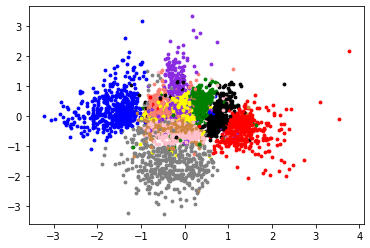

In [31]:
test_loader = torch.utils.data.DataLoader(test_dataset_binary, batch_size=batch_size,
                                         sampler=SubsetRandomSampler(list(range(5000))))
display_latents(model, test_loader)

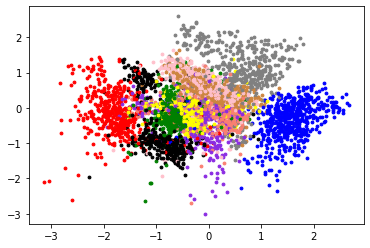

In [80]:
test_loader = torch.utils.data.DataLoader(test_dataset_binary, batch_size=batch_size,
                                         sampler=SubsetRandomSampler(list(range(5000))))
display_latents(model, test_loader)

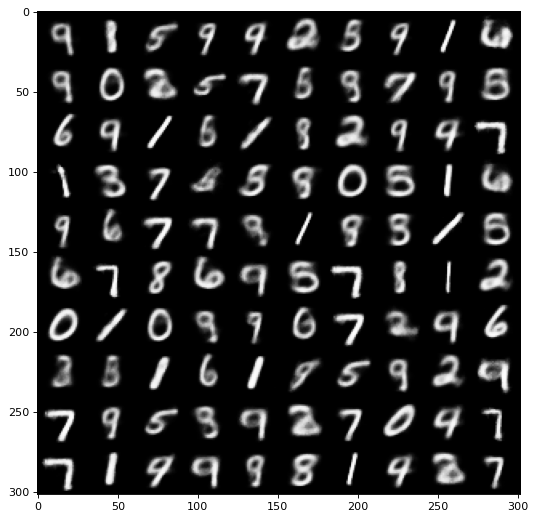

In [81]:
noise = False
n = 100

figure(figsize=(8, 8), dpi=80)

with torch.no_grad():
    z = torch.randn(n, 2).to(device)
    reconstructed = model.decoder(z)
    if noise:
        z = torch.randn_like(mu) * log_std.exp() + mu
    else:
        z = reconstructed
imgs = (torch.reshape(z, (-1, 1, 28, 28)) * 255)

nrows = 10
grid = torchvision.utils.make_grid(imgs, nrows)
grid = grid.detach().cpu().numpy()[1, :, :]  # from CHW to HWC
plt.imshow(1 - grid, cmap='Greys')

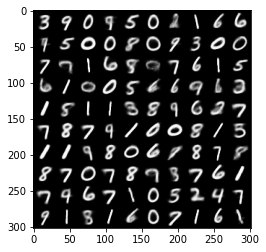

In [32]:
noise = False
n = 100

#figure(figsize=(8, 8), dpi=80)

with torch.no_grad():
    z = torch.randn(n, 2).to(device)
    reconstructed = model.decoder(z)
    if noise:
        z = torch.randn_like(mu) * log_std.exp() + mu
    else:
        z = reconstructed
imgs = (torch.reshape(z, (-1, 1, 28, 28)) * 255)

nrows = 10
grid = torchvision.utils.make_grid(imgs, nrows)
grid = grid.detach().cpu().numpy()[1, :, :]  # from CHW to HWC
plt.imshow(1 - grid, cmap='Greys')

In [3]:

model = VAE(28 * 28, 2).to(device).float()
train_loader = torch.utils.data.DataLoader(train_dataset_binary, batch_size=64,
                                           sampler=SubsetRandomSampler(list(range(N_train))))
val_loader = torch.utils.data.DataLoader(train_dataset_binary, batch_size=64,
                                         sampler=SubsetRandomSampler(list(range(N_train, N_train + N_val))))
train_custom_loss_VAE(model, train_loader, epochs=5)

Epoch [1 / 5] average reconstruction error: 231.685435
Epoch [2 / 5] average reconstruction error: 191.194450
Epoch [3 / 5] average reconstruction error: 187.896815
Epoch [4 / 5] average reconstruction error: 186.217491
Epoch [5 / 5] average reconstruction error: 184.786210


([], [], [], 184.7862099670278, 0, 0)